In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

100%|██████████| 1.04G/1.04G [00:47<00:00, 23.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


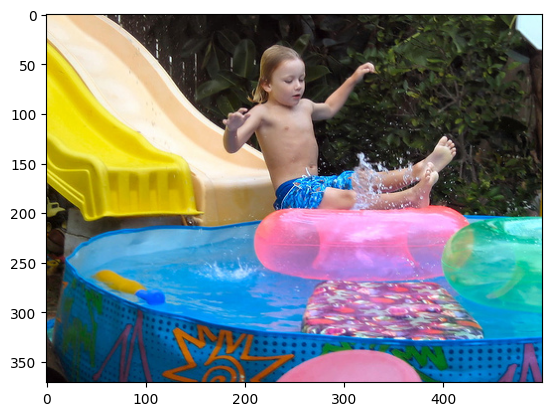

In [ ]:
image_name = "1077546505_a4f6c4daa9.jpg"
image_id = image_name.split('.')[0]
img_path = os.path.join(path, "Images", image_name)
image = Image.open(img_path)
plt.imshow(image)

In [ ]:
data = pd.read_csv("/root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
features={}
directory=os.path.join(path,'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path=directory +'/'+ img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [ ]:
with open(os.path.join(path,'captions.txt'),'r') as File:
    next(File)
    captions_file=File.read()

In [ ]:
mapping = {}
for line in tqdm(captions_file.split('\n')):
    tokens = line.split(',')
    #Skips lines with fewer than 2 characters (likely blank lines)
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
def preprocessing(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

preprocessing(mapping)

In [ ]:
#Used to extract all captions from the mapping dictionary into a single list
all_captions = [caption for key in mapping for caption in mapping[key]]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)

In [ ]:
# Save the tokenizer object to a pickle file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
# Get the image IDs
image_ids = list(mapping.keys())

# Split into train and test sets (90% train, 10% test)
train, test = train_test_split(image_ids, test_size=0.1, random_state=42)

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [] , [] ,[]
    n = 0
    while True:
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            n += 1
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1.clear()  # Clears the content of X1
                X2.clear()  # Clears the content of X2
                y.clear()   # Clears the content of y
                n = 0

In [ ]:
# image feature layers
#4096 is the output of second last layer of the vgg16
inputs1=Input(shape=(4096,),name="image")
a=Dropout(0.3)(inputs1)
X=Dense(256,activation='relu')(a)

# sequence feature layers
inputs2=Input(shape=(max_length,),name="text")
c=Embedding(vocab_size,256)(inputs2)
d=Dropout(0.3)(c)
Y=LSTM(256)(d)



decoder1=add([X , Y])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)         │ (None, 35)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image (InputLayer)        │ (None, 4096)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 35, 256)        │      2,172,160 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 4096)           │              0 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 35, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      1,048,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8485)           │      2,180,645 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,992,741 (22.86 MB)

 Trainable params: 5,992,741 (22.86 MB)

 Non-trainable params: 0 (0.00 B)

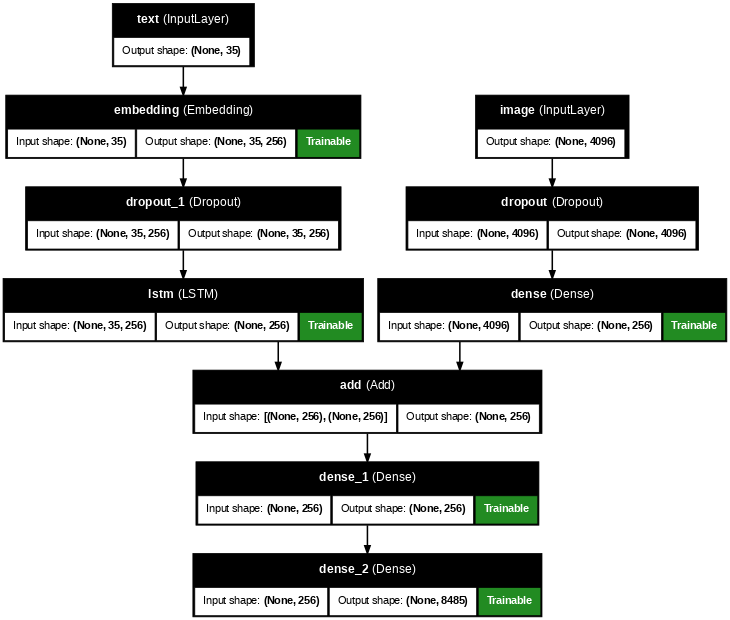

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    dpi=55,
    show_layer_activations=False,
    show_trainable=True
)

In [ ]:
epochs=12
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 77s 312ms/step - loss: 5.7238
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 4.0232
227/227 ━━━━━━━━━━━━━━━━━━━━ 71s 313ms/step - loss: 3.5401
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 3.2459
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - loss: 3.0445
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 310ms/step - loss: 2.8959
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 308ms/step - loss: 2.7859
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 305ms/step - loss: 2.6929
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 303ms/step - loss: 2.6082
227/227 ━━━━━━━━━━━━━━━━━━━━ 69s 304ms/step - loss: 2.5293
227/227 ━━━━━━━━━━━━━━━━━━━━ 70s 307ms/step - loss: 2.4630
227/227 ━━━━━━━━━━━━━━━━━━━━ 72s 319ms/step - loss: 2.4056


In [ ]:
def convert_to_word(number, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == number:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = convert_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(path, "Images", image_name)
    image = Image.open(img_path)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print(y_pred)
    plt.imshow(image)

startseq brown dog is playing with rope in the grass endseq


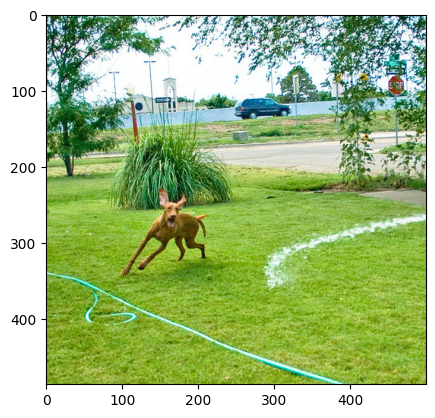

In [ ]:
generate_caption("1019077836_6fc9b15408.jpg")

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = [] , []

for key in tqdm(test):

    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

    # calcuate BLEU score
#Unigram
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#Bigram
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.548361
BLEU-2: 0.325769


In [ ]:
model.save('model.h5')

In [ ]:
!pip install gtts

In [ ]:
# listen to predicted text
from gtts import gTTS
from IPython.display import Audio, display

In [ ]:
caption_text = ' '.join(y_pred)

# Now, replace 'startseq' and 'endseq' and strip the caption
caption_text = caption_text.replace('startseq', '').replace('endseq', '').strip()
# Display the predicted caption
print("Predicted Caption:", caption_text)

# Step 1: Generate the audio for the caption using gTTS
tts = gTTS(caption_text, lang='en')
audio_path = "predicted_caption.mp3"
tts.save(audio_path)

# Step 2: Display the audio player before the image
print("Playing the predicted caption audio:")
display(Audio(audio_path, autoplay=True))

Predicted Caption: two dogs are in the water
Playing the predicted caption audio:
